# Chapter 5. Fine-tuning Large Language Models

## 5.4 Implementation of natural language inference, semantic similarity calculation, and multiple choice question answering models

### 5.4.3 Multiple Choice Question Answer

#### Preparing the Environment

In [1]:
!pip -q install transformers[ja,torch] datasets matplotlib japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 58.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 59.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [2]:
from transformers.trainer_utils import set_seed

# Fixed random number seed to 42
set_seed(42)

#### Preparing the Dataset

In [3]:
from pprint import pprint
from datasets import load_dataset

# Load the JCommonsenseQA data from the llm-book/JGLUE repository on Hugging Face Hub
train_dataset = load_dataset(
    "llm-book/JGLUE", name="JCommonsenseQA", split="train"
)
valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JCommonsenseQA", split="validation"
)
# Display in a readable format using pprint
pprint(train_dataset[0])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

{'choice0': '世界',
 'choice1': '写真集',
 'choice2': '絵本',
 'choice3': '論文',
 'choice4': '図鑑',
 'label': 2,
 'q_id': 0,
 'question': '主に子ども向けのもので、イラストのついた物語が書かれているものはどれ？'}


In [4]:
pprint(train_dataset.features)

{'choice0': Value(dtype='string', id=None),
 'choice1': Value(dtype='string', id=None),
 'choice2': Value(dtype='string', id=None),
 'choice3': Value(dtype='string', id=None),
 'choice4': Value(dtype='string', id=None),
 'label': ClassLabel(names=['choice0',
                            'choice1',
                            'choice2',
                            'choice3',
                            'choice4'],
                     id=None),
 'q_id': Value(dtype='int64', id=None),
 'question': Value(dtype='string', id=None)}


#### Tokenizer

In [5]:
from transformers import AutoTokenizer

# Specify the model name on Hugging Face Hub
model_name = "cl-tohoku/bert-base-japanese-v3"
# Load the tokenizer from the model name
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

#### Visualizing Dataset Statistics

100%|██████████| 8939/8939 [00:03<00:00, 2681.56it/s]


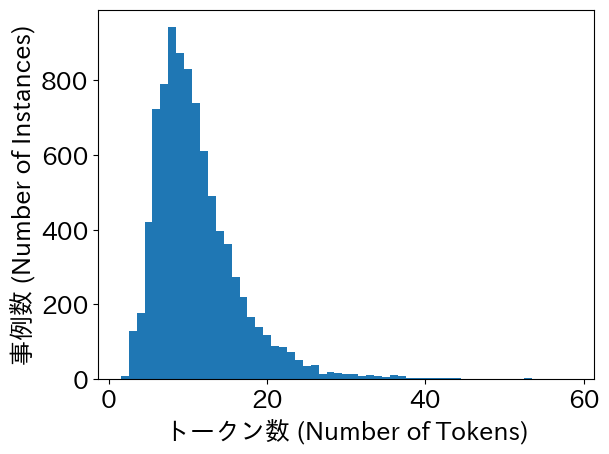

100%|██████████| 1119/1119 [00:00<00:00, 2862.81it/s]


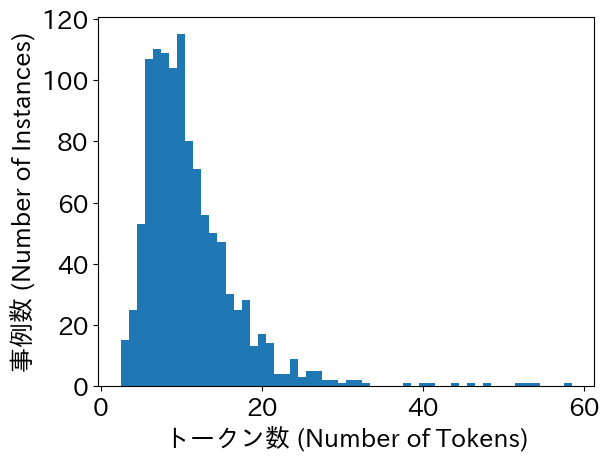

In [6]:
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18  # Increase the font size

def visualize_question_length(dataset: Dataset):
    """Draw a graph of the distribution of token counts in questions within the dataset"""
    # Count the length of questions in the dataset
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data["question"]))
        length_counter[length] += 1

    # Draw a bar graph from the values of length_counter
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("トークン数 (Number of Tokens)")
    plt.ylabel("事例数 (Number of Instances)")
    plt.show()

visualize_question_length(train_dataset)
visualize_question_length(valid_dataset)

100%|██████████| 8939/8939 [00:04<00:00, 1887.61it/s]


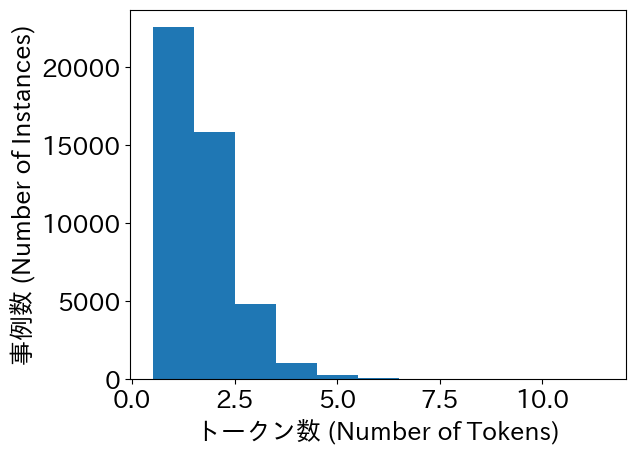

100%|██████████| 1119/1119 [00:00<00:00, 1363.58it/s]


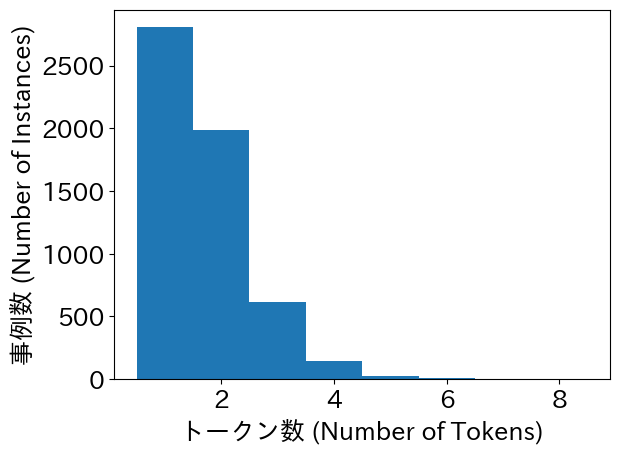

In [7]:
def visualize_choice_length(dataset: Dataset):
    """Draw a graph of the distribution of token counts in choices within the dataset"""
    # Count the length of choices in the dataset
    length_counter = Counter()
    for data in tqdm(dataset):
        for i in range(5):
            length = len(tokenizer.tokenize(data[f"choice{i}"]))
            length_counter[length] += 1

    # Draw a bar graph from the values of length_counter
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("トークン数 (Number of Tokens)")
    plt.ylabel("事例数 (Number of Instances)")
    plt.show()

visualize_choice_length(train_dataset)
visualize_choice_length(valid_dataset)

#### Preprocessing Dataset

In [8]:
from transformers import BatchEncoding

def preprocess_multiple_choice(
    example: dict[str, str]
) -> BatchEncoding:
    """Convert multiple-choice question answering examples to IDs"""
    # Calculate the number of choices based on the number of keys starting with "choice"
    num_choices = sum(
        key.startswith("choice") for key in example.keys()
    )

    # Concatenate the question with each choice and pass to the tokenizer
    choice_list = [example[f"choice{i}"] for i in range(num_choices)]  # Each choice
    repeated_question_list = [example["question"]] * num_choices  # The question repeated for each choice
    encoded_example = tokenizer(
        repeated_question_list, choice_list, max_length=64
    )

    # If a label is included in the input, add it to the output
    if "label" in example:
        encoded_example["labels"] = example["label"]
    return encoded_example

In [9]:
from transformers import AutoTokenizer

example = train_dataset[0]
encoded_example = preprocess_multiple_choice(example)  # Preprocessing the example
for choice in range(5):
    # Decode the original string from IDs
    print(tokenizer.decode(encoded_example["input_ids"][choice]))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 世界 [SEP]
[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 写真 集 [SEP]
[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 絵本 [SEP]
[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 論文 [SEP]
[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 図鑑 [SEP]


In [10]:
encoded_train_dataset = train_dataset.map(
    preprocess_multiple_choice,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_multiple_choice,
    remove_columns=valid_dataset.column_names,
)

Map:   0%|          | 0/8939 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Map:   0%|          | 0/1119 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


In [11]:
print(encoded_train_dataset[0])

{'input_ids': [[2, 13182, 16044, 12994, 464, 12518, 457, 384, 14930, 464, 12584, 449, 13360, 430, 14220, 494, 456, 12483, 12518, 465, 19382, 46, 3, 12575, 3], [2, 13182, 16044, 12994, 464, 12518, 457, 384, 14930, 464, 12584, 449, 13360, 430, 14220, 494, 456, 12483, 12518, 465, 19382, 46, 3, 13409, 6460, 3], [2, 13182, 16044, 12994, 464, 12518, 457, 384, 14930, 464, 12584, 449, 13360, 430, 14220, 494, 456, 12483, 12518, 465, 19382, 46, 3, 20647, 3], [2, 13182, 16044, 12994, 464, 12518, 457, 384, 14930, 464, 12584, 449, 13360, 430, 14220, 494, 456, 12483, 12518, 465, 19382, 46, 3, 15252, 3], [2, 13182, 16044, 12994, 464, 12518, 457, 384, 14930, 464, 12584, 449, 13360, 430, 14220, 494, 456, 12483, 12518, 465, 19382, 46, 3, 22929, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0

#### Mini Batch Construction

In [12]:
import torch
from transformers import BatchEncoding

def collate_fn_multiple_choice(
    features: list[BatchEncoding],
) -> dict[str, torch.Tensor]:
    """Build a mini-batch from inputs for multiple-choice question answering"""
    # Align with the preprocess_multiple_choice function by setting the label name to "labels"
    label_name = "labels"

    batch_size = len(features)
    num_choices = len(features[0]["input_ids"])

    # Gather inputs for each choice into a single list
    flat_features = []
    for feature in features:
        flat_features += [
            {k: v[i] for k, v in feature.items() if k != label_name}
            for i in range(num_choices)
        ]

    # Perform padding for inputs for each choice
    flat_batch = tokenizer.pad(flat_features, return_tensors="pt")

    # Group inputs for each choice per original batch
    # Transform Tensor shape from (batch_size * num_choices, max_sequence_length)
    # to (batch_size, num_choices, max_sequence_length)
    batch = {
        k: v.view(batch_size, num_choices, -1)
        for k, v in flat_batch.items()
    }

    # If labels are included in the input, gather them in a batch and convert to Tensor
    if label_name in features[0]:
        labels = [feature[label_name] for feature in features]
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
    return batch

In [13]:
batch_size = 4
encoded_examples = [
    preprocess_multiple_choice(train_dataset[i])
    for i in range(batch_size)
]
batch = collate_fn_multiple_choice(encoded_examples)
pprint({name: tensor.size() for name, tensor in batch.items()})

{'attention_mask': torch.Size([4, 5, 40]),
 'input_ids': torch.Size([4, 5, 40]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 5, 40])}


#### Prepare the Model

In [14]:
from transformers import AutoModelForMultipleChoice

model = AutoModelForMultipleChoice.from_pretrained(
    model_name,
    num_labels=train_dataset.features["label"].num_classes,
)

config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/447M [00:00<?, ?B/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
model(**batch)

MultipleChoiceModelOutput(loss=tensor(1.4848, grad_fn=<NllLossBackward0>), logits=tensor([[-0.3795, -0.3648, -0.1021, -0.4802, -0.2815],
        [-0.0629,  0.0435, -0.4554, -0.1143, -0.2337],
        [-0.5503, -0.5156, -0.6268, -0.5746, -0.5088],
        [-0.4857, -0.4155, -0.5902, -0.2060, -0.2705]],
       grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)

#### Training Execution

In [16]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_jcommonsenseqa",  # Folder for saving results
    per_device_train_batch_size=32,  # Batch size during training
    per_device_eval_batch_size=32,  # Batch size during evaluation
    learning_rate=2e-5,  # Learning rate
    lr_scheduler_type="linear",  # Type of learning rate scheduler
    warmup_ratio=0.1,  # Specify the length of learning rate warmup
    num_train_epochs=3,  # Number of training epochs
    save_strategy="epoch",  # Checkpoint save timing
    logging_strategy="epoch",  # Logging timing
    evaluation_strategy="epoch",  # Timing of evaluation with the validation set
    load_best_model_at_end=True,  # Load the best model based on the development set after training
    metric_for_best_model="accuracy",  # Metric to determine the best model
    fp16=True,  # Enable automatic mixed precision computation
)

In [17]:
import numpy as np

def compute_accuracy(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    """Calculate accuracy from predicted labels and true labels"""
    predictions, labels = eval_pred
    # predictions are the scores for each label
    # The index with the highest score is considered as the predicted label
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=collate_fn_multiple_choice,
    args=training_args,
    compute_metrics=compute_accuracy,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.777600,0.462997,0.831099
2,0.405700,0.451782,0.835567
3,0.284000,0.474018,0.839142


TrainOutput(global_step=840, training_loss=0.489127440679641, metrics={'train_runtime': 257.342, 'train_samples_per_second': 104.208, 'train_steps_per_second': 3.264, 'total_flos': 2308609199230020.0, 'train_loss': 0.489127440679641, 'epoch': 3.0})

#### Evaluating the Model After Training

In [19]:
# Evaluate the model on the validation set
eval_metrics = trainer.evaluate(encoded_valid_dataset)
pprint(eval_metrics)

{'epoch': 3.0,
 'eval_accuracy': 0.839142091152815,
 'eval_loss': 0.4740176796913147,
 'eval_runtime': 3.0804,
 'eval_samples_per_second': 363.27,
 'eval_steps_per_second': 11.362}


#### Save the Model

Save on Google Drive

In [ ]:
# Mount on Google Drive
from google.colab import drive

drive.mount("drive")

Mounted at drive


In [ ]:
# Copy the saved model to the Google Drive folder
!mkdir -p drive/MyDrive/llm-book
!cp -r output_jcommonsenseqa drive/MyDrive/llm-book

Save on Hugging Face Hub



In [ ]:
from huggingface_hub import login

login()

In [ ]:
# Repository name on Hugging Face Hub
# Replace "YOUR-ACCOUNT" with your own username
repo_name = "YOUR-ACCOUNT/bert-base-japanese-v3-output_jcommonsenseqa"
# Upload the tokenizer and model
tokenizer.push_to_hub(repo_name)
model.push_to_hub(repo_name)